## Executive Summary

In this notebook, I looked at the house prices data, performed basic data cleaning and EDA, fit the data with a list of common regression models and compared their performances. I chose *XGBoostRegression*, without hyperparameter tuning, as the final model and achieved a PL score of 0.13921 (root mean square log error) on the test dataset, ranking at around 50% on Kaggle (as of May 2020).

**Data cleaning**  
- Drop 4 columns with over 80% of missing value
- Separated categorical and numeric variables according to datetype (except for 'MSSubClass')
- Replaced missing values with a new category 'ZZZ' for categorical variables 
- Replaced missing values with median for numeric variables


**EDA**:   
- Visualized categorical variables and their relationships with target variable using countplot and barplot
- Visualized numeric variables and their relationships with target variable using histplot, box plot, and scatter plot with target variable
- Correlation matrix (heat map) for numeric variables
- Correlation and p-value between numeric features and target variable


**Feature engineering / selection**   
- Applied StandardScaler to all numeric variables
- Created new features from categorical variables using OneHotEncoding (with drop_first=True)
- All features are used for all models


**Modeling**  
- Used 5-fold cross-validation to compare a list of regression models (default parameters)
- XGBOOST and GradientBoost have the best performance in terms of 'neg_mean_absolute_error'
- Looked at the feature significance from XGBOOST but no further feature selection is performed


**Future improvements**  

- The modeling results from SVR and Multi-variate Linear Regression seem to be completely off. It is worth to investigate why. Multicolinearity could be a problem but I am not yet convinced this is the only reason.
- Some numerical variables can be transformed to categorical (e.g. Year, Month)
- We can spend more time on Linear Models (Ridge, LASSO). This would require more work on feature transformation (normality check + log / box-cox transformation), and feature extraction/selection. Would be good to practice these technics. 
- Use GridSearch to tune hyperparameters. 



In [105]:
# import
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import datetime

from sklearn import preprocessing, linear_model, ensemble, model_selection, metrics, svm, tree, neighbors, neural_network
import xgboost

%matplotlib inline

In [107]:
# function to make submission csv file with predicted values
def make_submission_file(y_pred, path='data/submissions/'):
    df = pd.DataFrame({'Id': df_test.index, 
                      'SalePrice': y_pred})
    file = path + 'sub_{}.csv'.format(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S"))
    if not os.path.exists(path):
        os.makedirs(path)

    df.to_csv(file, index=False)


## Meet the data

### Download the data

In [1]:
# download and unzip data: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
# alternatively, check kaggle API: https://github.com/Kaggle/kaggle-api

In [4]:
os.listdir('data/')

['data_description.txt', 'sample_submission.csv', 'test.csv', 'train.csv']

In [5]:
# load raw data
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

### Take a quick look at the data structure

**Observations**  

- 80 columns, of which 38 numeric and 42 str
- 19 columns have missing value, or which 'PoolQC', 'MiscFeature', 'Alley', 'Fence' have over 80% data missing; 'FireplaceQu' 47%, 'LotFrontage' 17%; the rest below 6%. 
- Consider dropping all features with higher than 17% missing value as a first step.
- Complete the columns with lower than 6% missing value using np.mean() or np.mode()
- For such a large data set, we need to use visualization to rule out obviouly not helpful variables. Then we can use a baseline model to investigate feature importance.


In [94]:
print("data shape:", df_train.shape, df_test.shape)
pd.set_option('display.max_columns', None)
df_train.head()

data shape: (1460, 81) (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [95]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [96]:
# inspect missing values in training set
df_train.isnull().mean().sort_values(ascending=False).head(20)

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageCond      0.055479
GarageType      0.055479
GarageYrBlt     0.055479
GarageFinish    0.055479
GarageQual      0.055479
BsmtExposure    0.026027
BsmtFinType2    0.026027
BsmtFinType1    0.025342
BsmtCond        0.025342
BsmtQual        0.025342
MasVnrArea      0.005479
MasVnrType      0.005479
Electrical      0.000685
Utilities       0.000000
dtype: float64

In [97]:
# separate numeric and str columns
df_num = df_train.select_dtypes(include=['int64', 'float64'])
df_obj = df_train.select_dtypes(include=['O'])
df_num.shape, df_obj.shape

((1460, 38), (1460, 43))

### Address some missing values

In [99]:
# concatenate two dfs into one to facilitate data cleaning
df_clean = df_train.drop('SalePrice', axis=1).append(df_test, ignore_index=True)

s = df_clean.isnull().mean().sort_values(ascending=False).head(50)
cols_missing = s[s>0].index
print(s[s>0], cols_missing)

# drop columns with missing > 80%
df_clean.drop(s[s>0.8].index, axis=1, inplace=True)
print("Dropped {} columns: ".format(len(df_train.columns)-1-len(df_clean.columns)), s[s>0.8].index.values)

PoolQC          0.996574
MiscFeature     0.964029
Alley           0.932169
Fence           0.804385
FireplaceQu     0.486468
LotFrontage     0.166495
GarageCond      0.054471
GarageQual      0.054471
GarageYrBlt     0.054471
GarageFinish    0.054471
GarageType      0.053786
BsmtCond        0.028092
BsmtExposure    0.028092
BsmtQual        0.027749
BsmtFinType2    0.027407
BsmtFinType1    0.027064
MasVnrType      0.008222
MasVnrArea      0.007879
MSZoning        0.001370
BsmtHalfBath    0.000685
Utilities       0.000685
Functional      0.000685
BsmtFullBath    0.000685
BsmtFinSF1      0.000343
Exterior1st     0.000343
Exterior2nd     0.000343
BsmtFinSF2      0.000343
BsmtUnfSF       0.000343
TotalBsmtSF     0.000343
SaleType        0.000343
Electrical      0.000343
KitchenQual     0.000343
GarageArea      0.000343
GarageCars      0.000343
dtype: float64 Index(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage',
       'GarageCond', 'GarageQual', 'GarageYrBlt', 'Gara

We might argue the treatment of **FireplaceQu (0.486468) and LotFrontage (0.166495)**. Let's take a closer look at them.

- FireplaceQu is a categorical variable. Missing value might mean that there is no fireplace. We can fill missing entries with NO_FP. 
- LotFrontage is numeric. Check quickly its correlation with SalePrice: significate correlation. Let's fill missing entries with median. 

For the rest of columns with missing values, we **fill 'ZZZ' for categorical variables and median for numeric variables**.

In [35]:
# an auxilary function to easily look at relationship between categorical variables and target variable
def plot_count_and_bar(x, y, data, figsize=(10, 4)):
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    sns.countplot(x=x, data=data, ax=ax[0])
    sns.barplot(x=x, y=y, data=data, ax=ax[1])

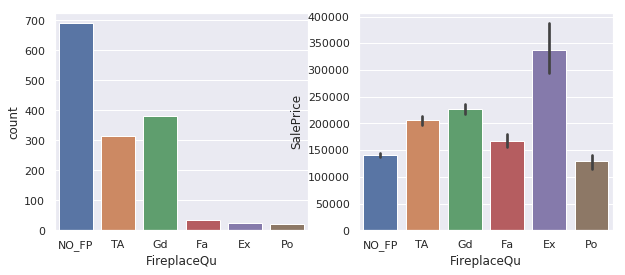

In [194]:
plot_count_and_bar(x='FireplaceQu', y='SalePrice', data=df_train[['FireplaceQu', 'SalePrice']].fillna('NO_FP'))

In [195]:
# calculate the correlation between LotFrontage and SalePrice 
r, p = stats.pearsonr(df_train['LotFrontage'].fillna(df_train['LotFrontage'].median()), df_train['SalePrice'])
print(r, p)

0.33477085313976 1.4469846007067933e-39


**Execute missing value decisions**

In [101]:
# fill missing values for FireplaceQu and LotFrontage
df_clean['FireplaceQu'] = df_clean['FireplaceQu'].fillna('ZZZ')
df_clean['LotFrontage'] = df_clean['LotFrontage'].fillna(df_train['LotFrontage'].median())

# complete other variables with missing values

remain_missing_cols = list(set(cols_missing) - set(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage']))

for col in remain_missing_cols:
    if col in df_num.columns.values:
        df_clean[col] = df_clean[col].fillna(df_train[col].median())
    else:
        df_clean[col] = df_clean[col].fillna('ZZZ')

print(df_clean.shape)

df_train_clean = df_clean.head(len(df_train))
df_train_clean.loc[:, 'SalePrice'] = df_train['SalePrice']
df_test_clean = df_clean.tail(len(df_test))

# save cleaned data to csv files
df_train_clean.to_csv('df_train_clean.csv', index=False)
df_test_clean.to_csv('df_test_clean.csv', index=False)

print(df_train_clean.shape, df_test_clean.shape)

(2919, 76)
(1460, 77) (1459, 76)


## EDA

In [133]:
# load cleaned data
df_train = pd.read_csv('df_train_clean.csv', index_col='Id')
df_test =  pd.read_csv('df_test_clean.csv', index_col='Id')

### Visualize categorical variables and their relationships with target variable

In [71]:
# we discovered 'MSSubClass' has numeric value but is more like a categorical variable
cat_cols = df_train.select_dtypes(['O']).columns.tolist() + ['MSSubClass']
print(cat_cols)

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition', 'MSSubClass']


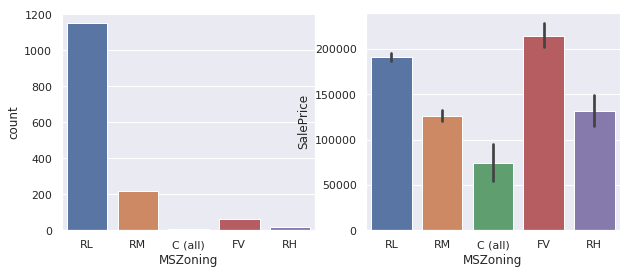

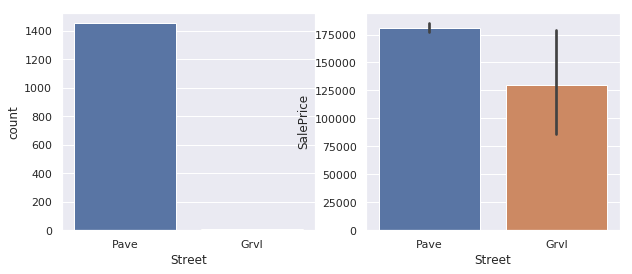

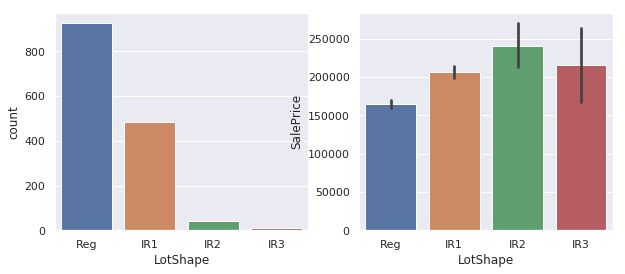

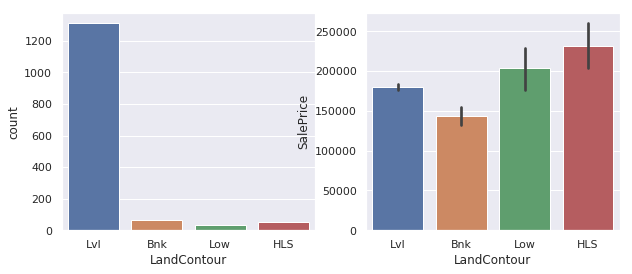

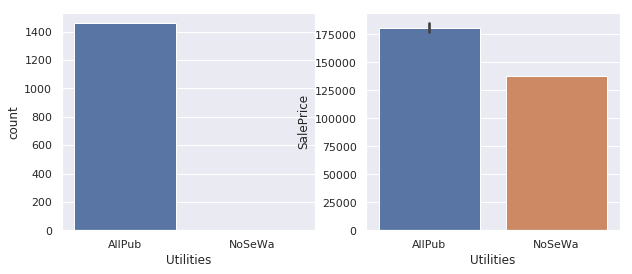

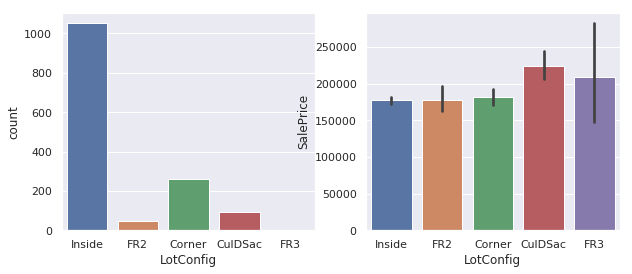

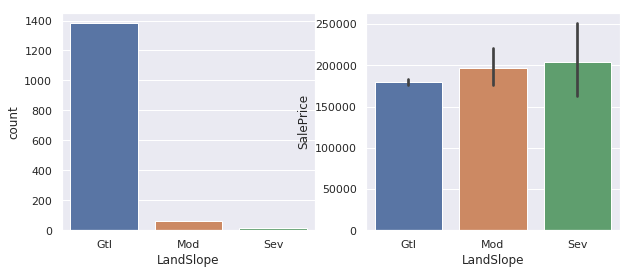

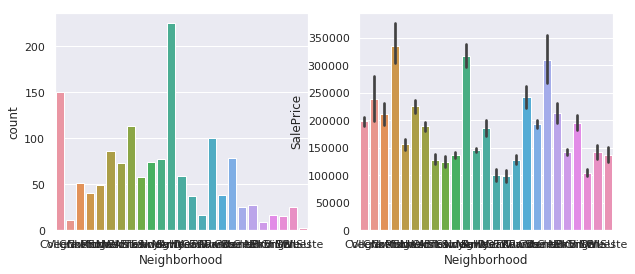

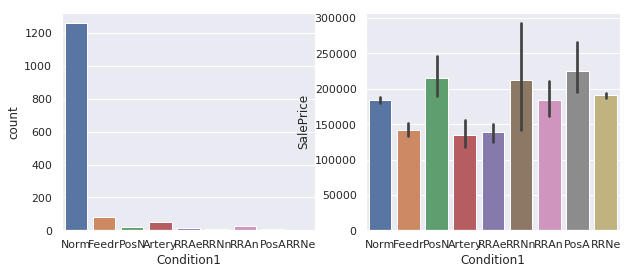

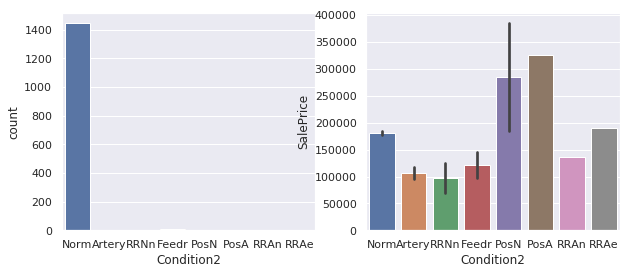

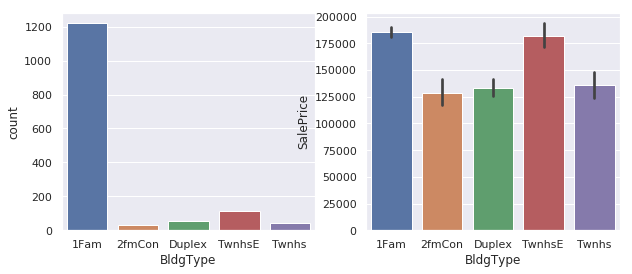

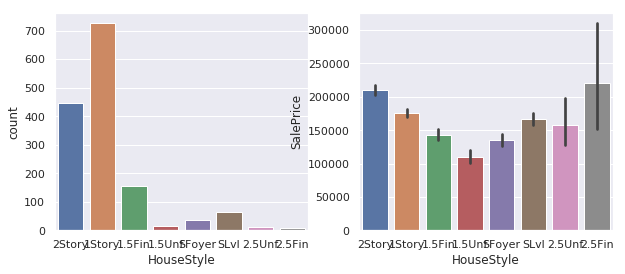

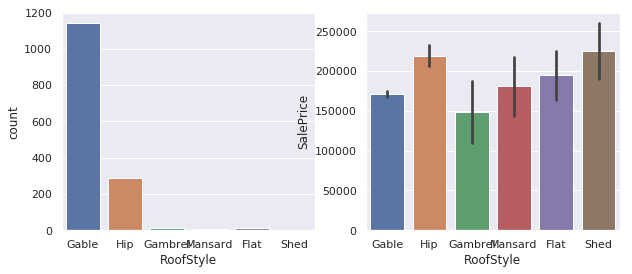

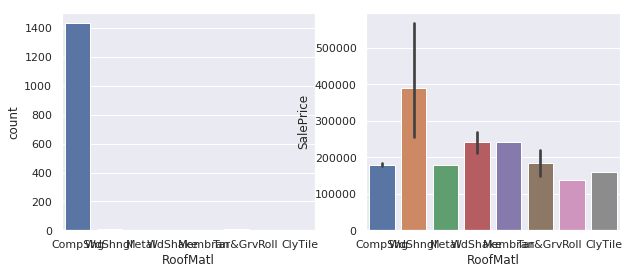

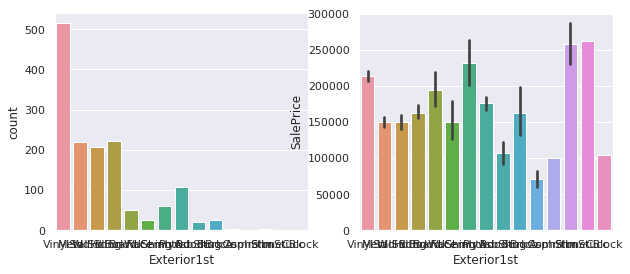

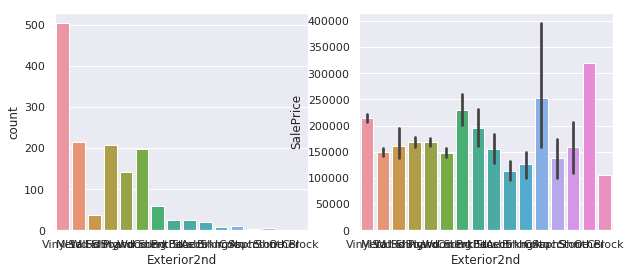

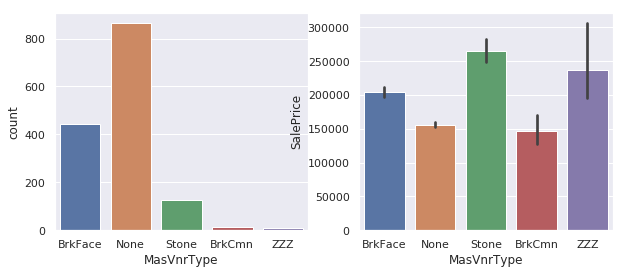

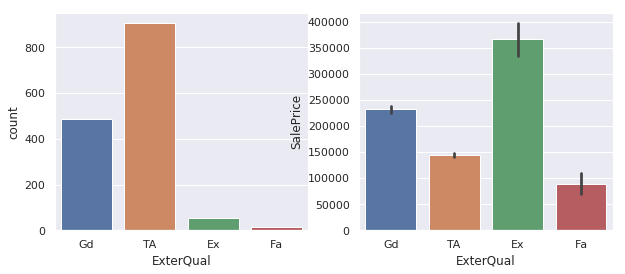

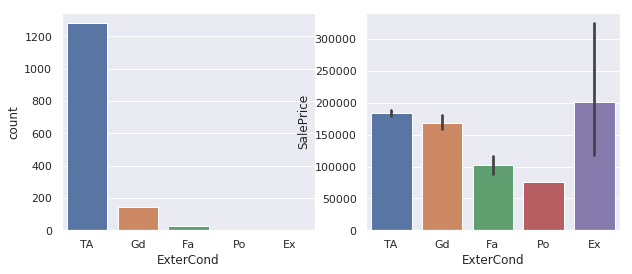

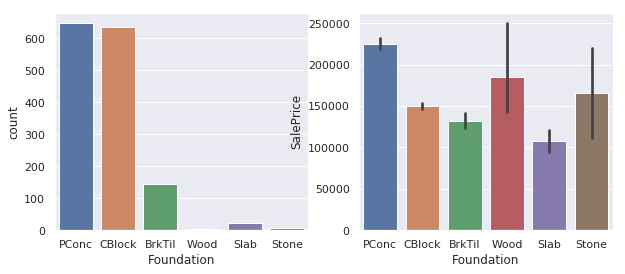

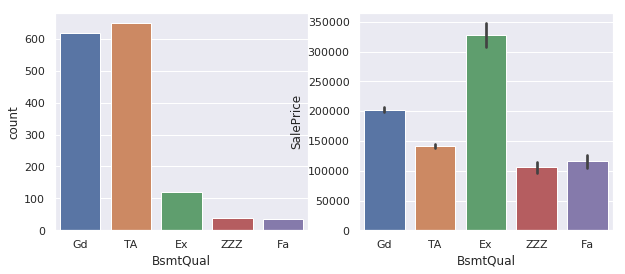

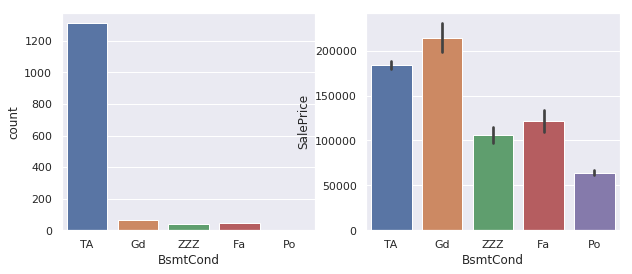

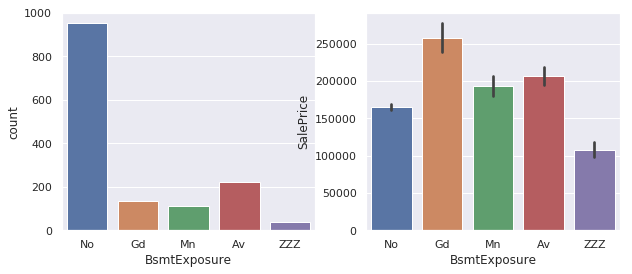

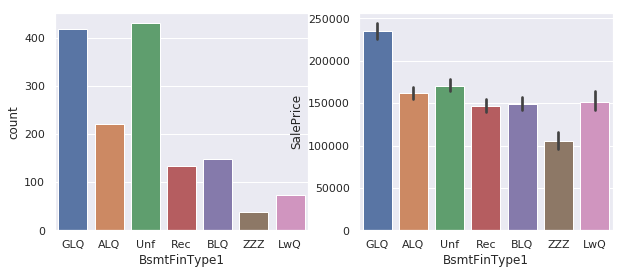

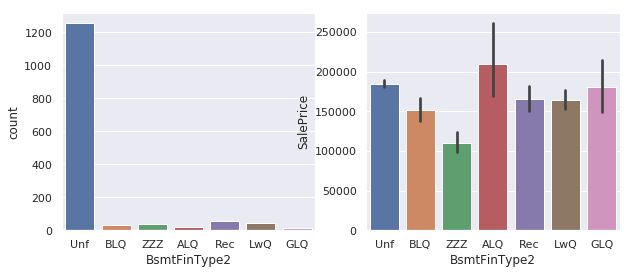

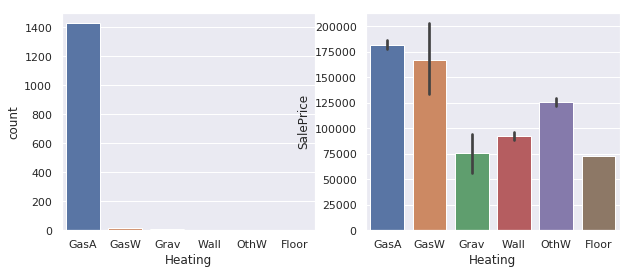

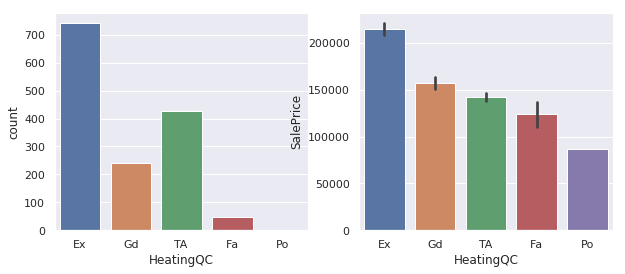

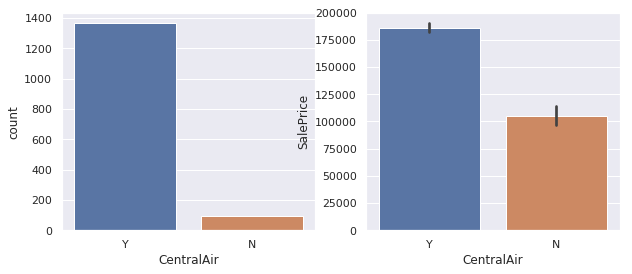

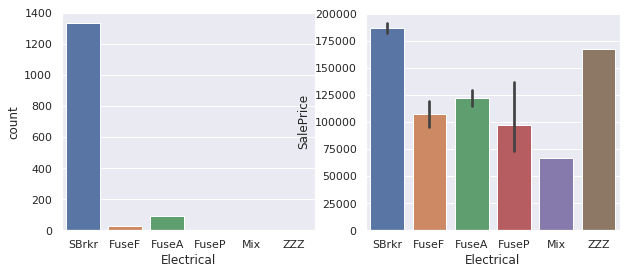

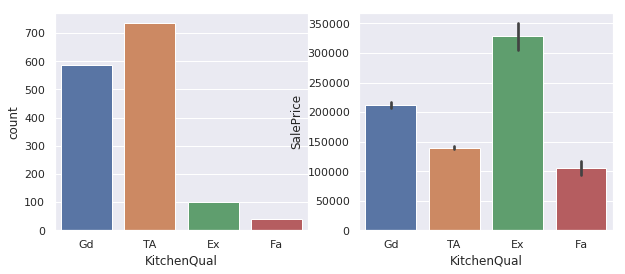

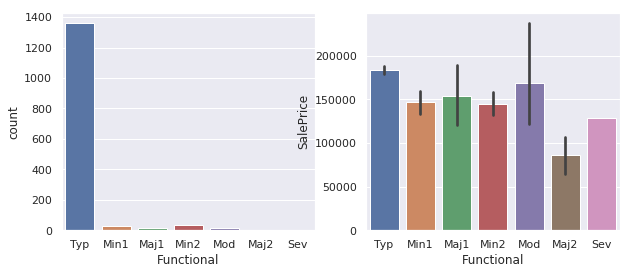

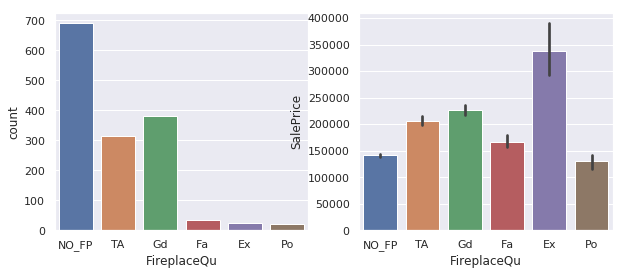

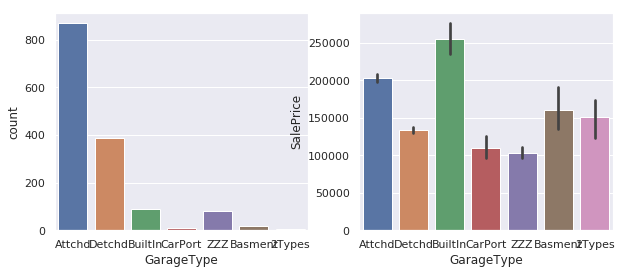

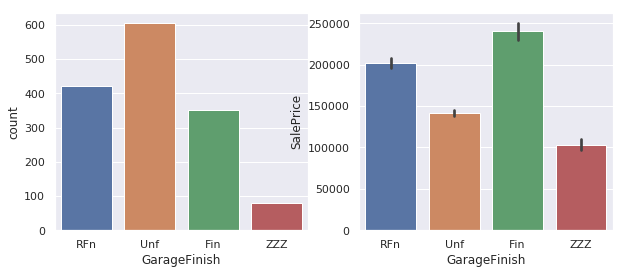

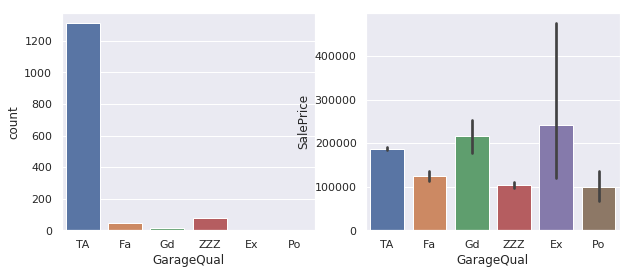

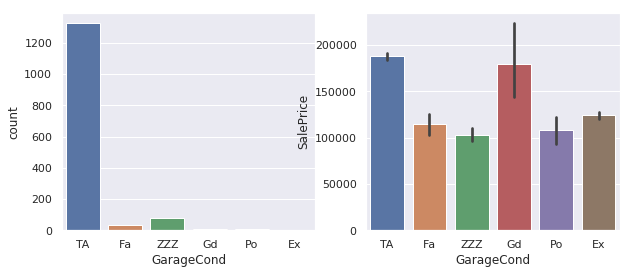

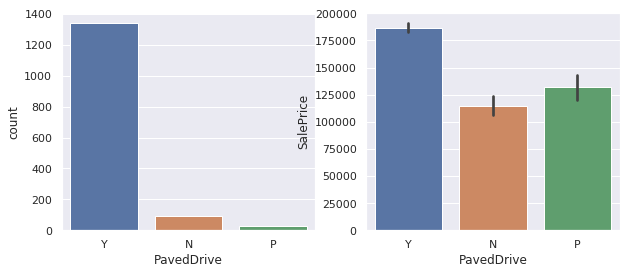

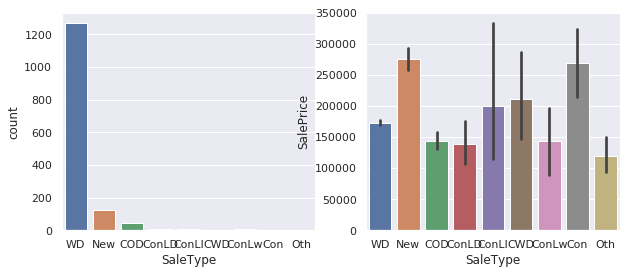

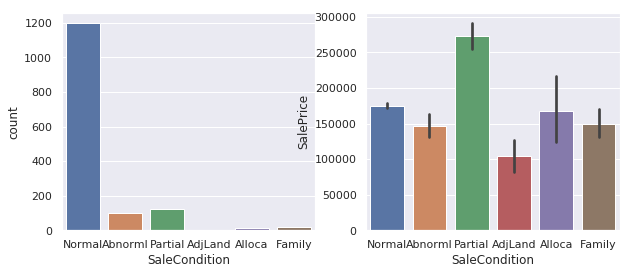

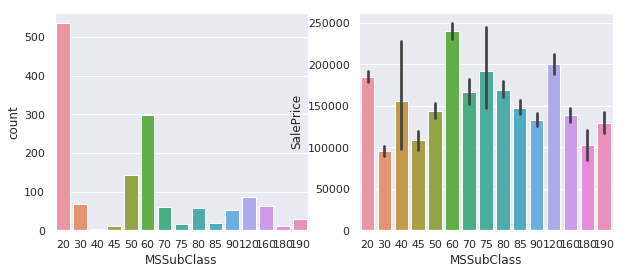

In [68]:
for col in cat_cols:
    plot_count_and_bar(x=col, y='SalePrice', data=df_train)

### Visualize numeric variables and their relationships with target variable

In [128]:
num_cols = df_train.select_dtypes(['int64', 'float64']).columns.tolist()
num_cols.remove('MSSubClass')
print(num_cols)

['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 432x288 with 0 Axes>

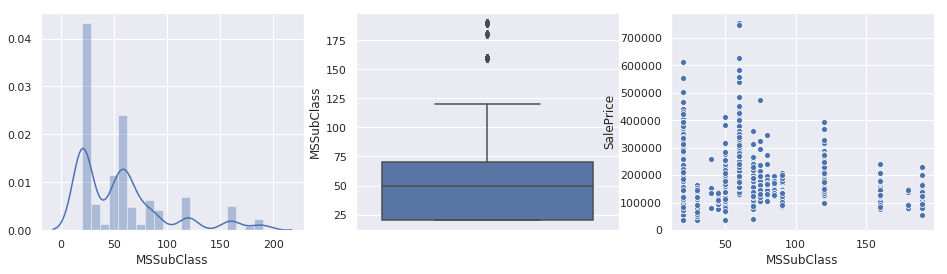

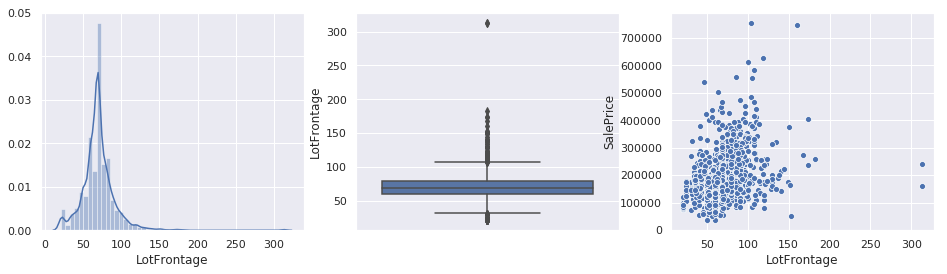

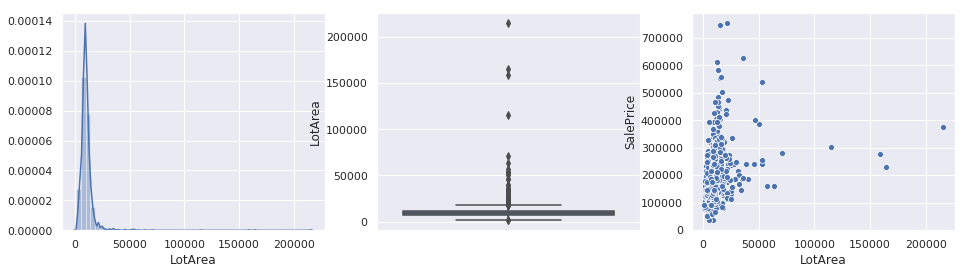

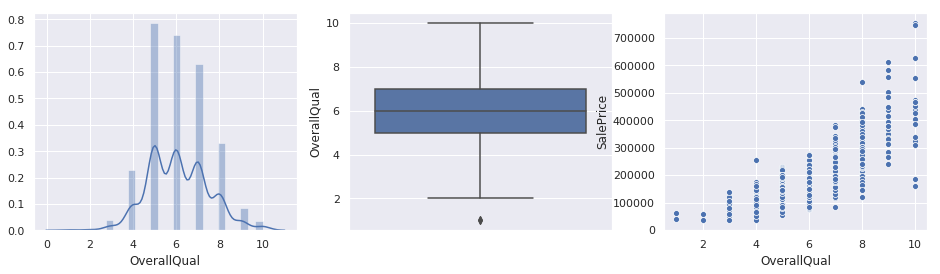

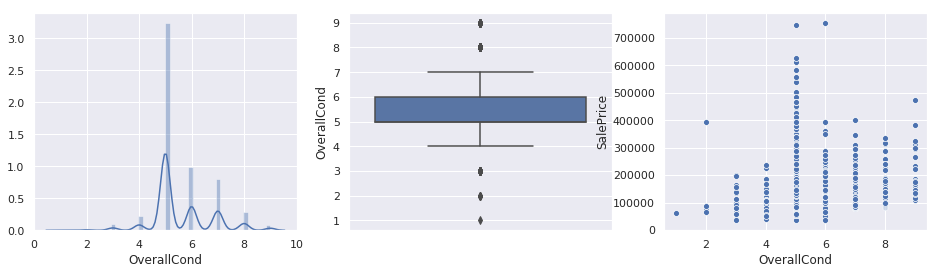

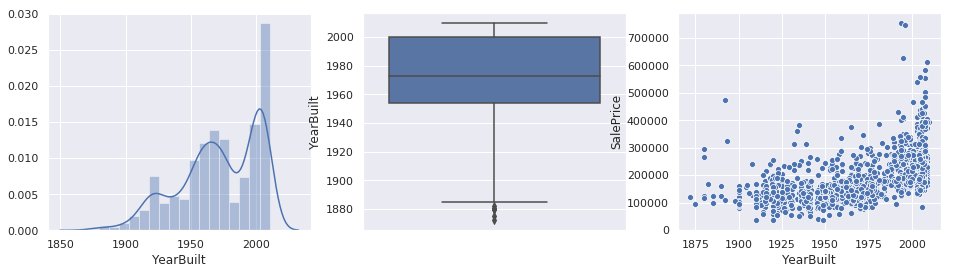

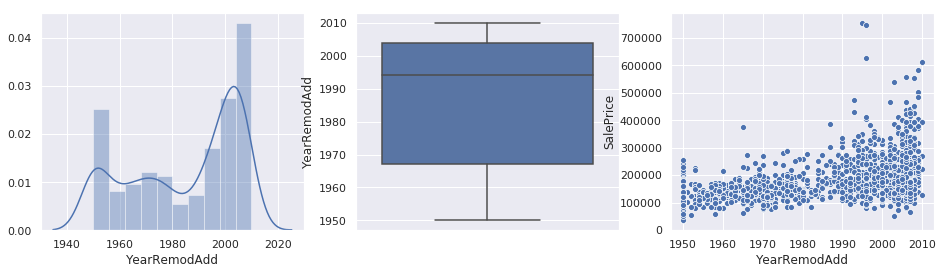

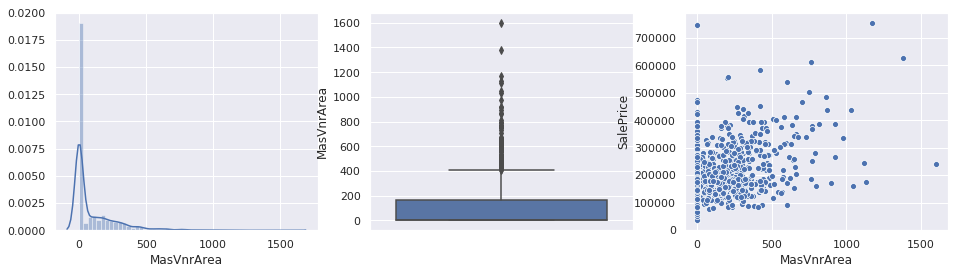

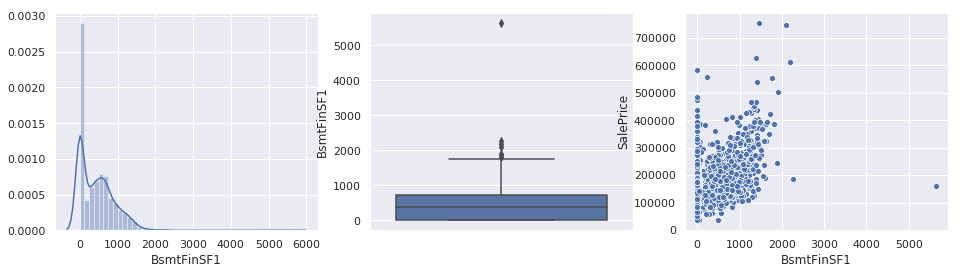

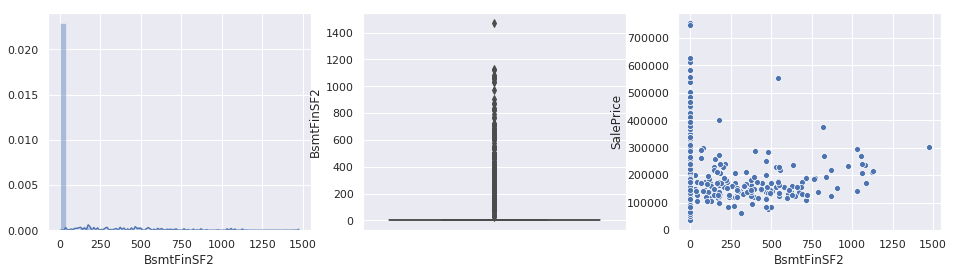

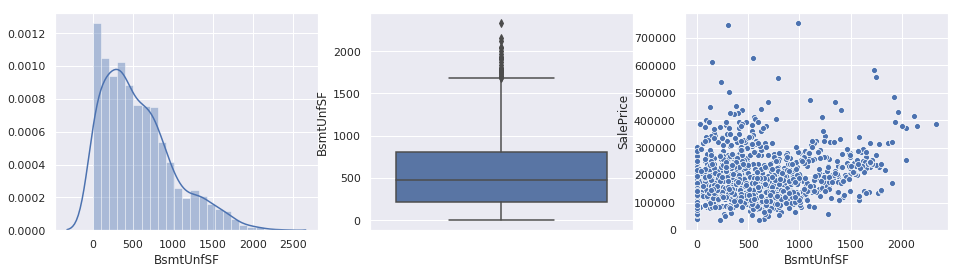

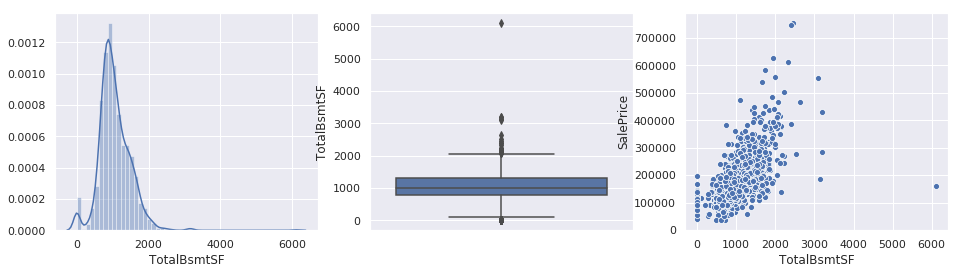

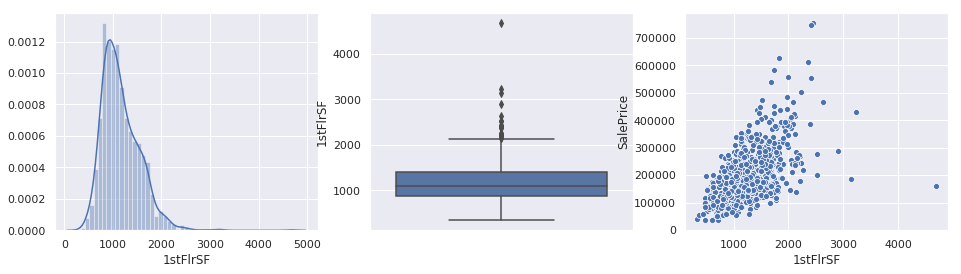

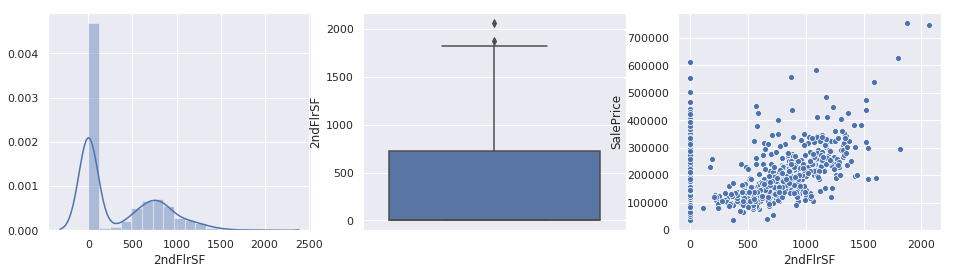

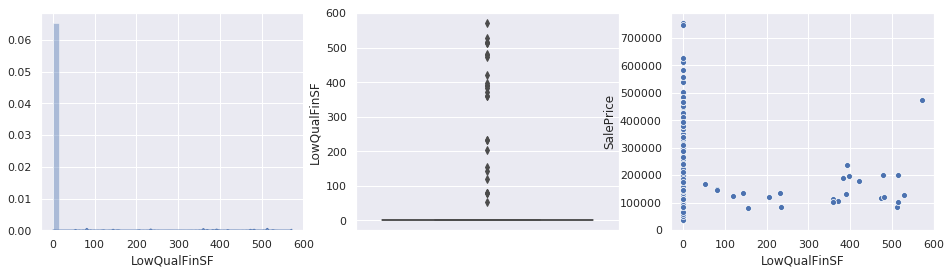

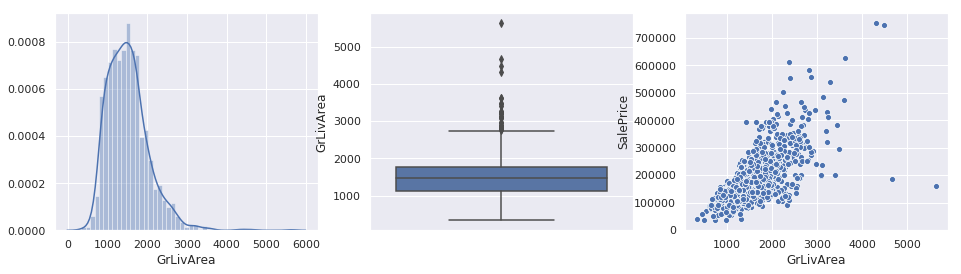

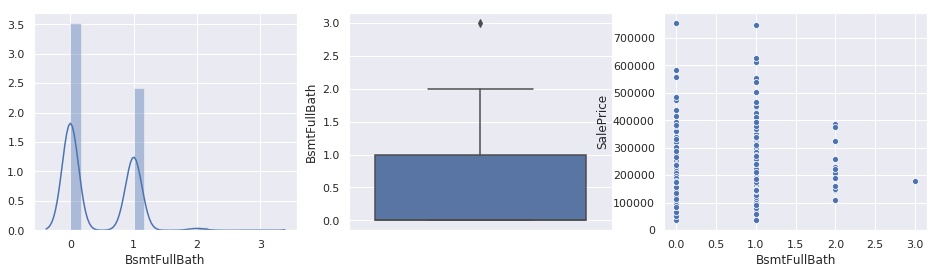

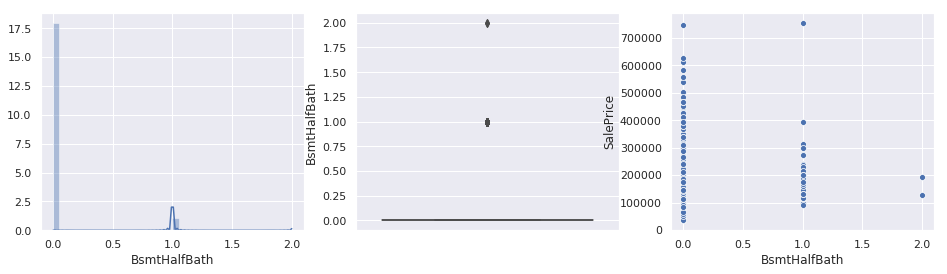

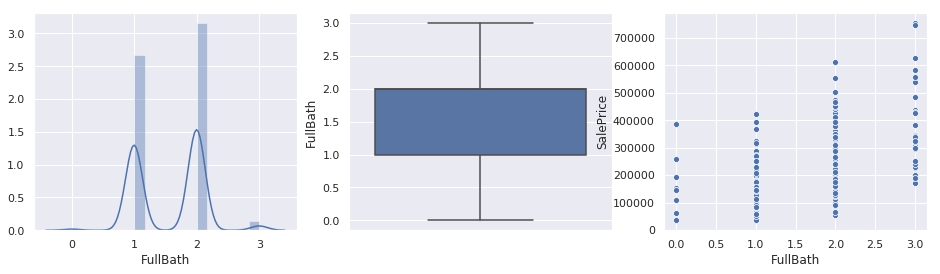

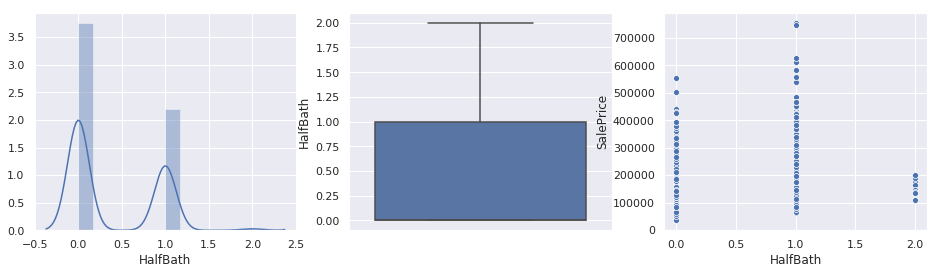

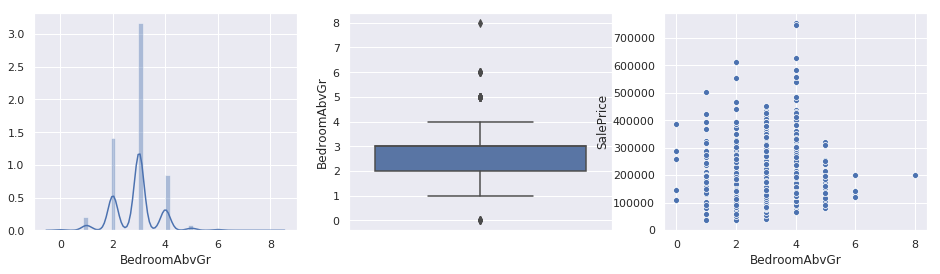

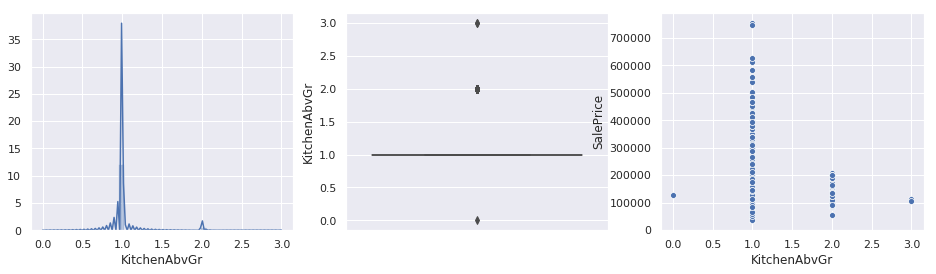

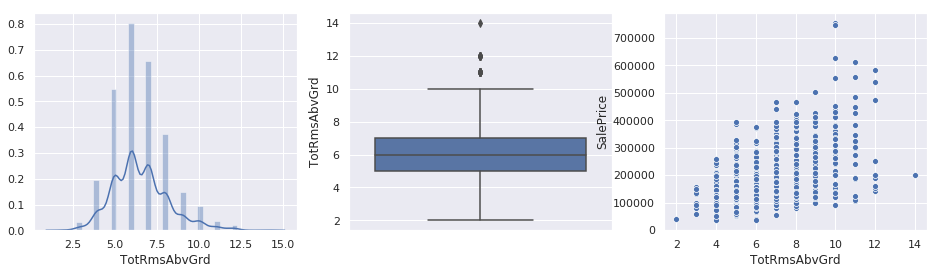

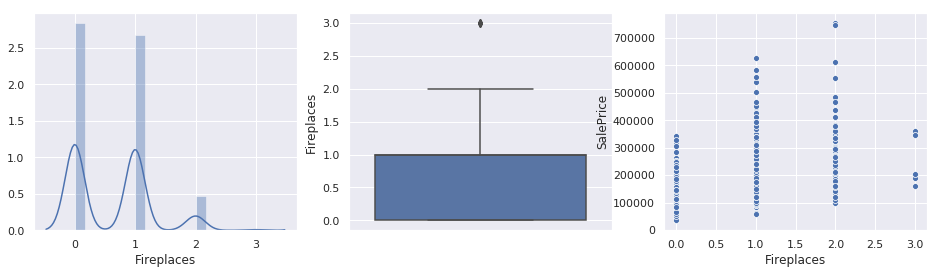

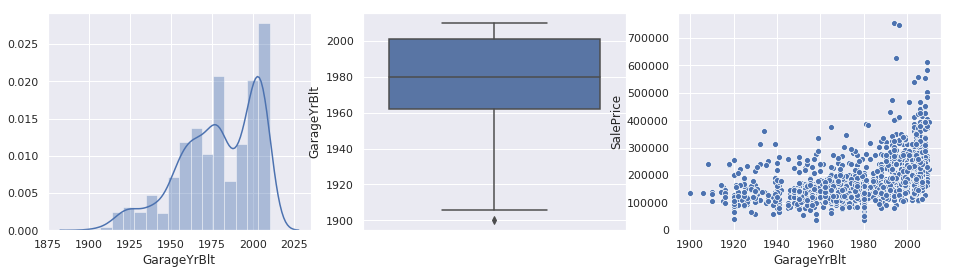

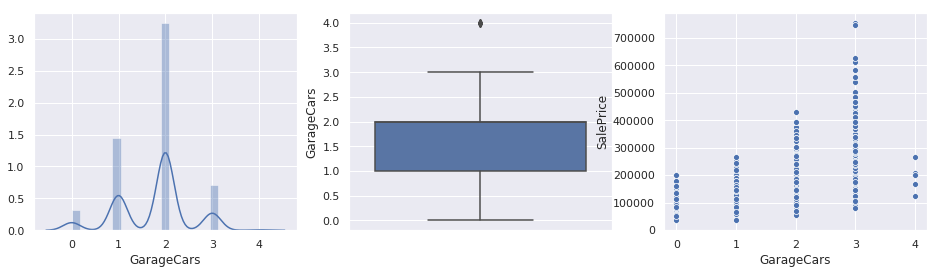

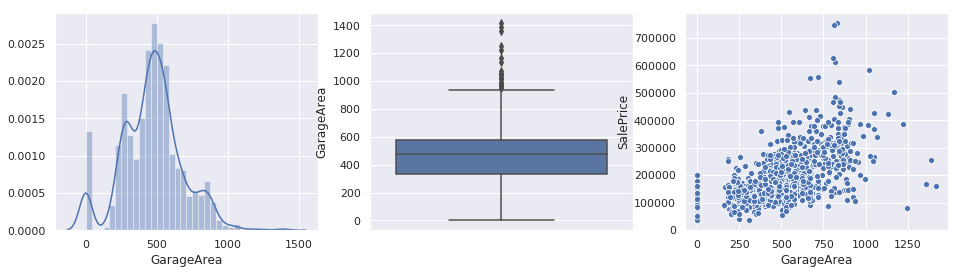

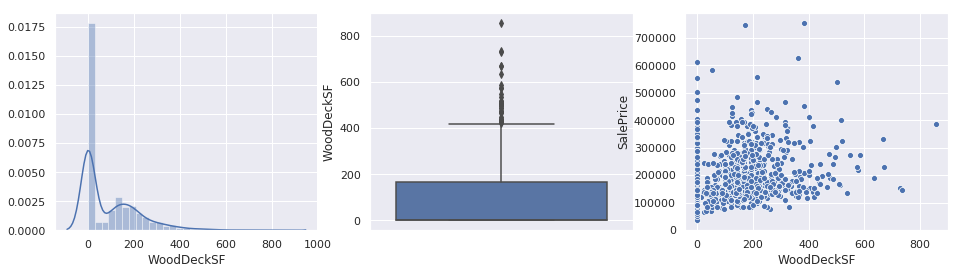

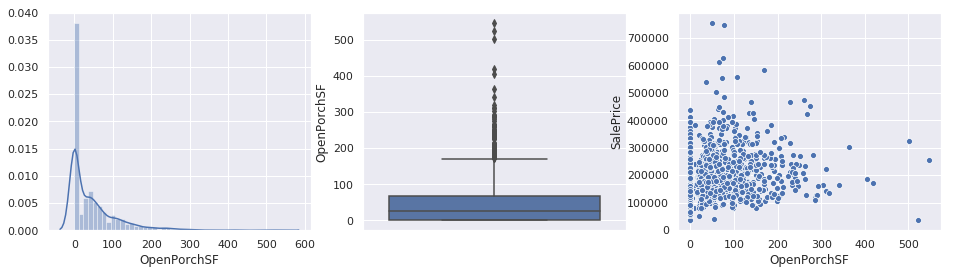

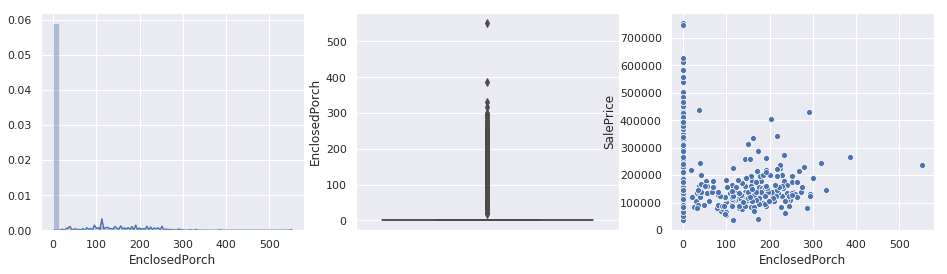

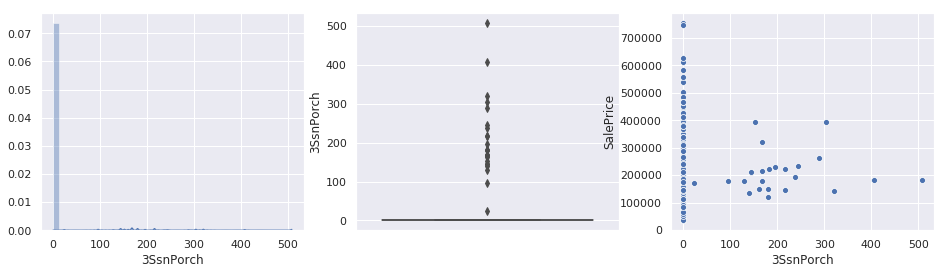

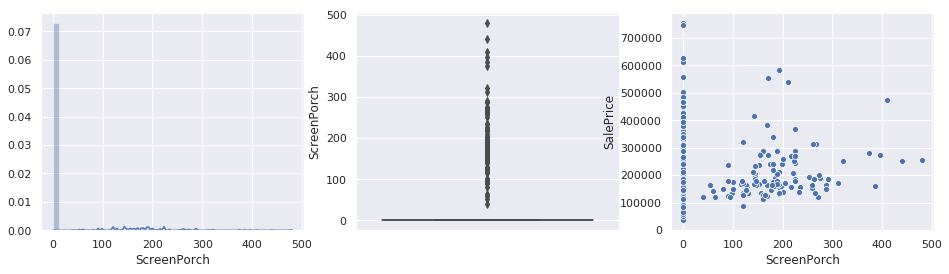

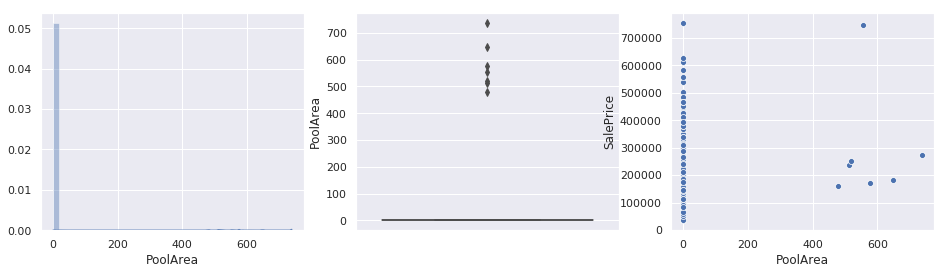

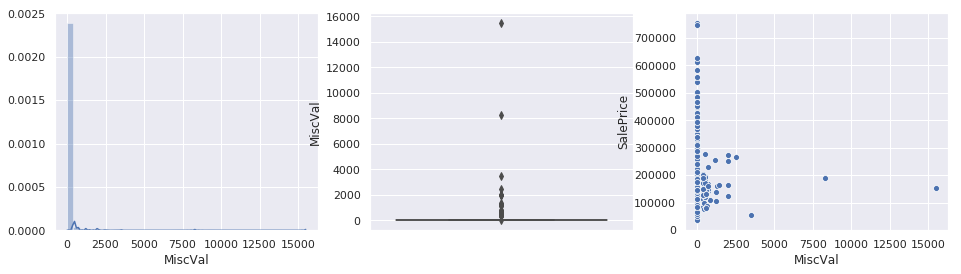

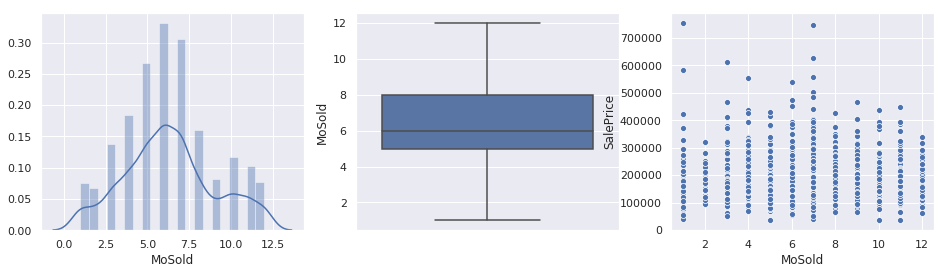

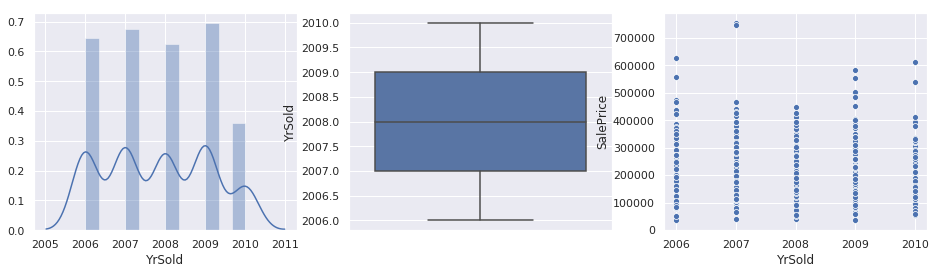

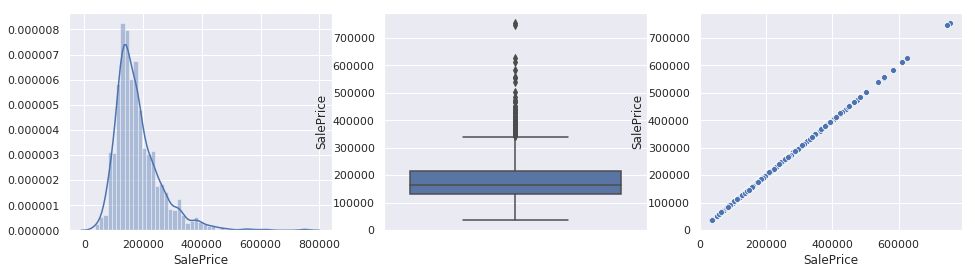

In [61]:
# hist, box plot; scatter plot with SalePrice

def plot_hist_box_and_scatter(x, y, data, figsize=(16, 4)):
    fig, ax = plt.subplots(1, 3, figsize=figsize)
    sns.distplot(data[x], ax=ax[0])
    sns.boxplot(x=x, data=data, ax=ax[1], orient='v')
    sns.scatterplot(x=x, y=y, data=data, ax=ax[2])

plt.tight_layout()
for col in num_cols:
    plot_hist_box_and_scatter(col, 'SalePrice', df_train)


### Look for correlations

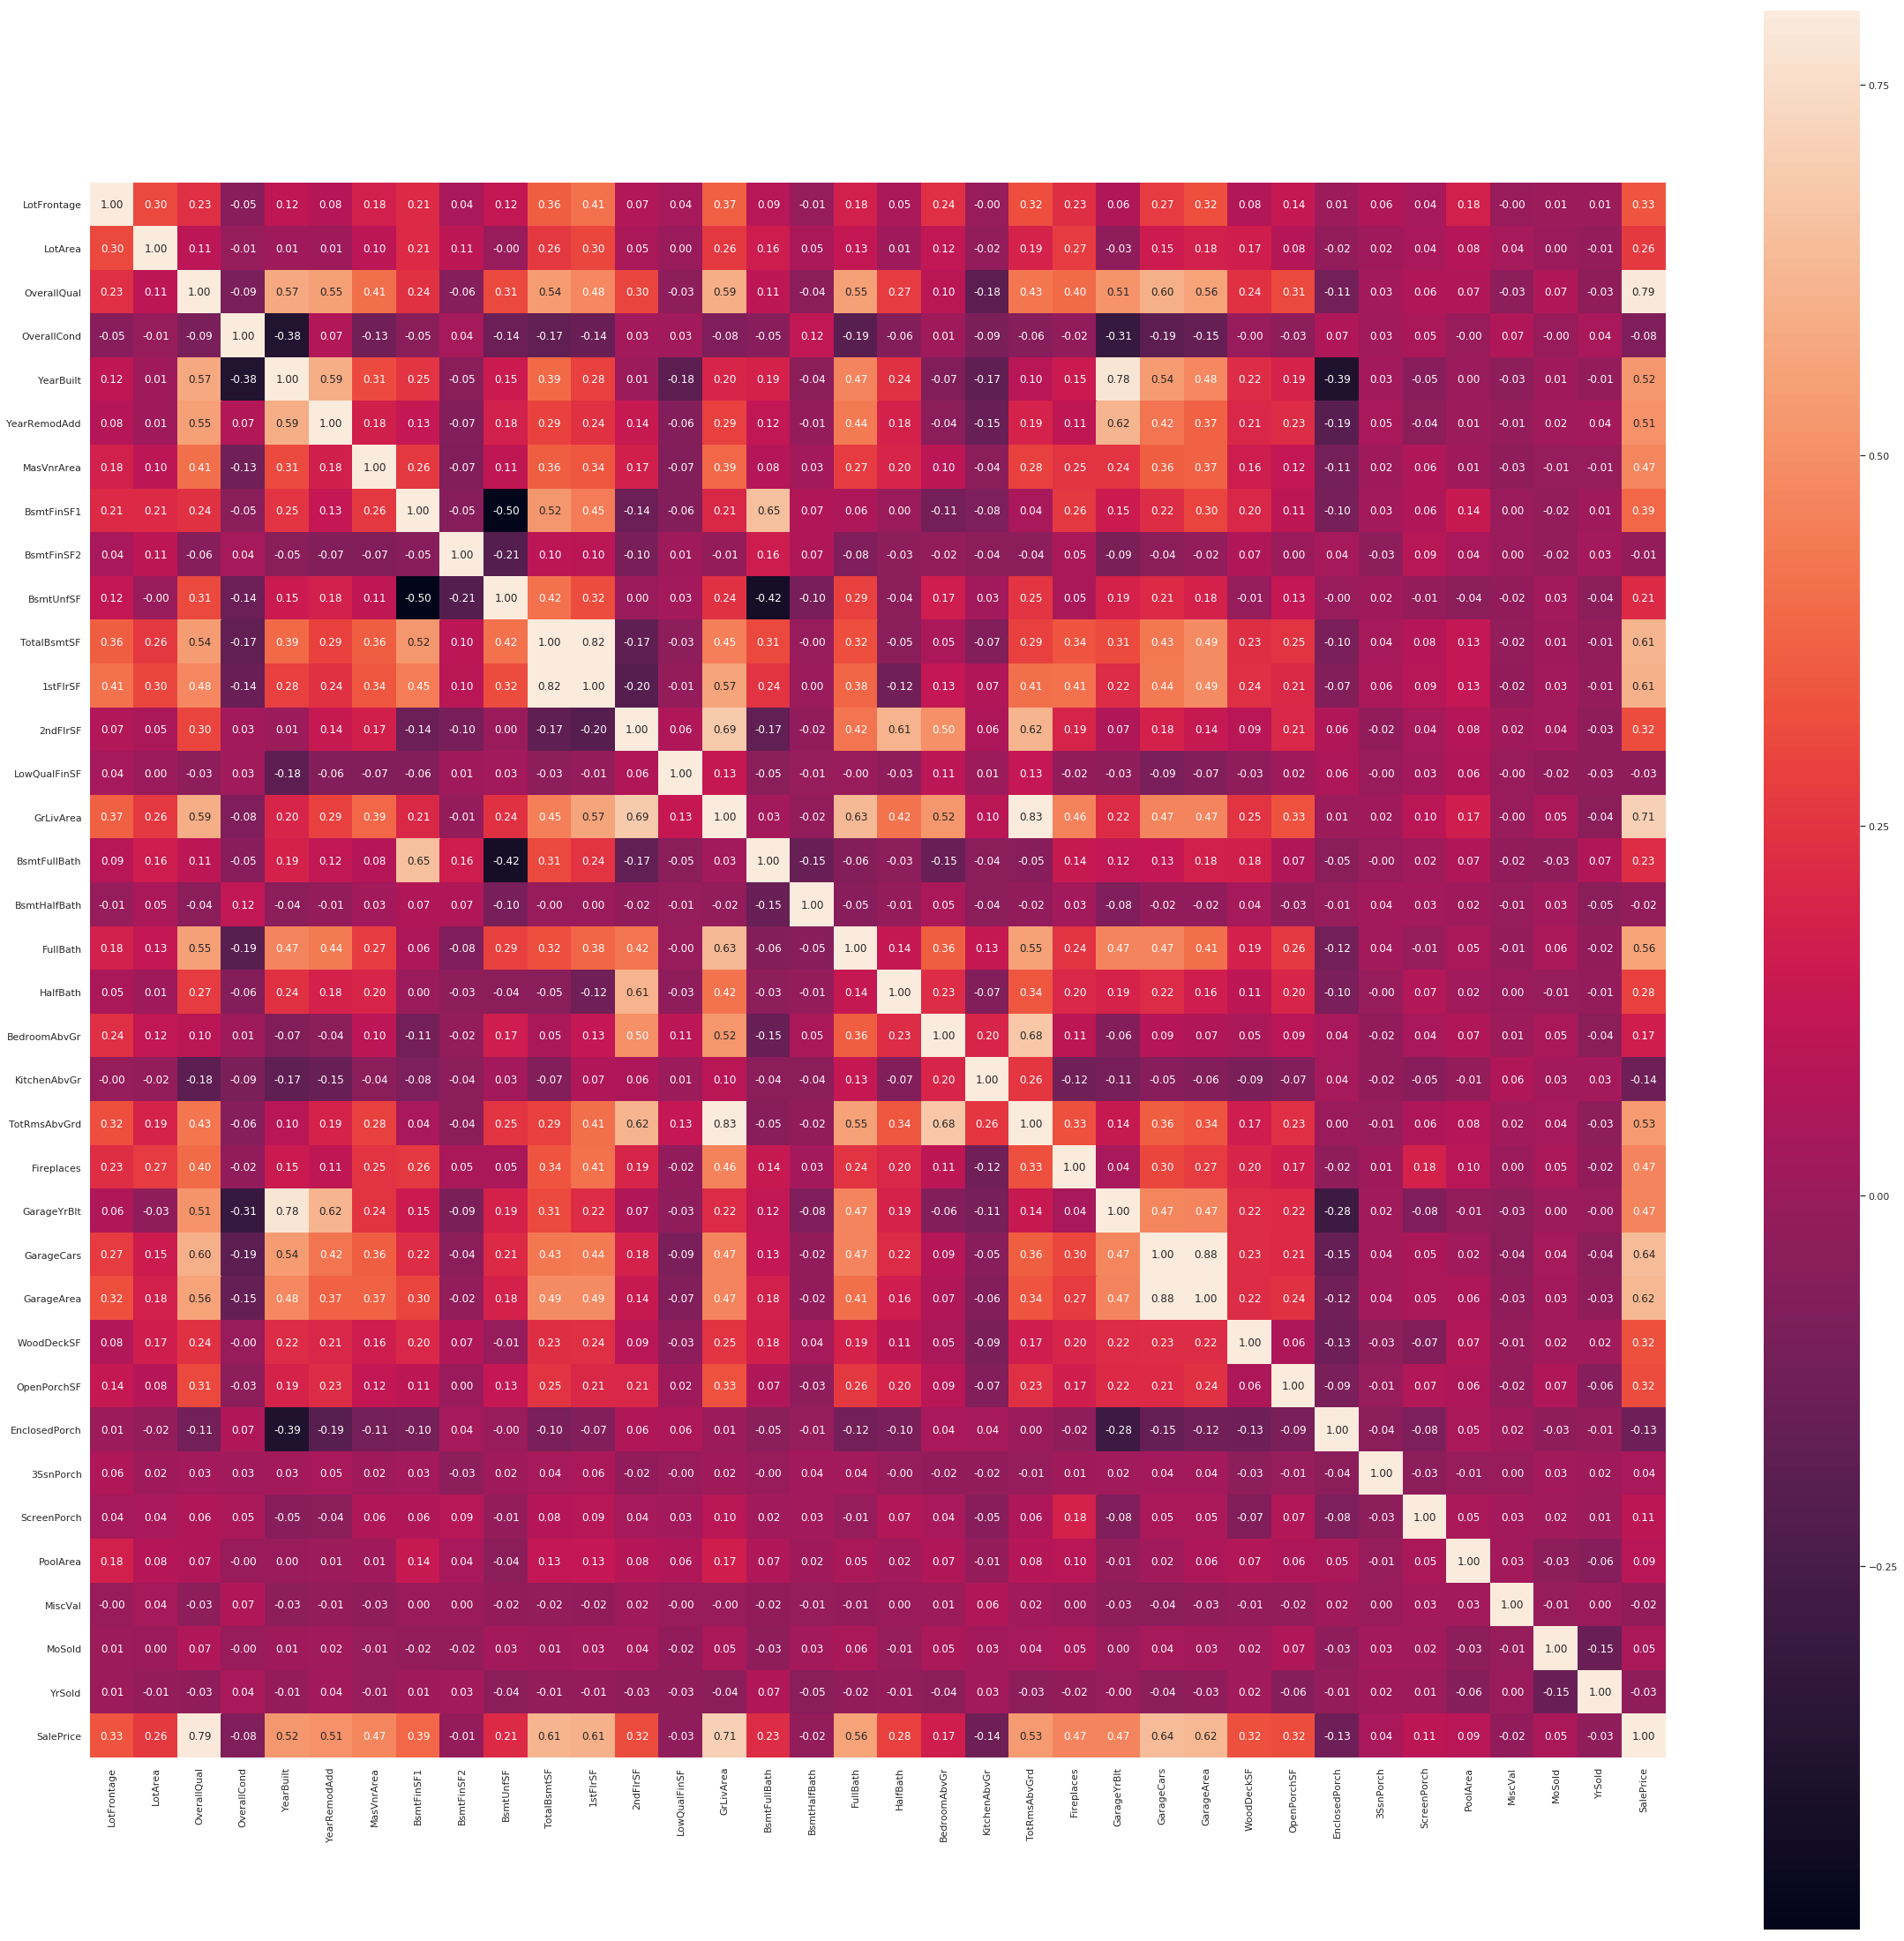

In [75]:
# correlation matrix heatmap -> pay attention to correlation with SalePrice; and multicolinearity
corrmat = df_train[num_cols].corr() 
f, ax = plt.subplots(figsize=(40,40))
sns.set(font_scale=1.0)
sns.heatmap(corrmat, vmax=.8, square=True, annot=True, fmt='.2f');

In [76]:
# p_values

from scipy import stats

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(stats.pearsonr(df[r], df[c])[1], 6)
    return pvalues

p_value_mat = calculate_pvalues(df_train[num_cols])

**Look at only correlation with SalePrice**

In [77]:
corr_sale_price = pd.DataFrame()
corr_sale_price.loc[:, 'Corr'] = corrmat['SalePrice']
corr_sale_price.loc[:, 'p_value'] = p_value_mat['SalePrice']
corr_sale_price.reindex(corr_sale_price['Corr'].abs().sort_values(ascending=False).index)

,Corr,p_value
SalePrice,1.000000,0
OverallQual,0.790982,0
GrLivArea,0.708624,0
GarageCars,0.640409,0
GarageArea,0.623431,0
TotalBsmtSF,0.613581,0
1stFlrSF,0.605852,0
FullBath,0.560664,0
TotRmsAbvGrd,0.533723,0
YearBuilt,0.522897,0


### Some take-aways from this round of EDA

Linear correlation:

- The most important variables are OverallQual, GrLivArea
- Next important variables are related to size and age of the house.

Collinearity:  
- We can see some variables exhibit high correlations, e.g  TotRmsAbvGrd & GrLivArea; GarageYrBlt & YearBuilt; GarageArea & GarageCars

Other:
- A few numeric variables contain a lot of zeros, can be extracted as separated features
- There are too many categorical variables, it would take too much time to look into them at this stage.
- From common sense, house prices in one ara are mostly determined by the size. It might make more sense to look at the relationship between variables and price per unit size rather than the overall house price. 


We will start with some simple model and look at feature importance. We can perform another round of feature extraction/engineering 

## Modeling

In [7]:
# load cleaned data
df_train = pd.read_csv('df_train_clean.csv', index_col='Id')
df_test =  pd.read_csv('df_test_clean.csv', index_col='Id')

### Prepare data for ML algos

If this gets complicated, we can create a data transformation pipeline

In [20]:
# separate categorical and numerical features
cat_features = df_train.select_dtypes(['O']).columns.tolist() + ['MSSubClass']

num_features = df_train.select_dtypes(['int64', 'float64']).columns.tolist()
num_features.remove('MSSubClass')
num_features.remove('SalePrice')

In [137]:
from sklearn import preprocessing

# encoding for cat features
df_combined = df_train.drop('SalePrice', axis=1).append(df_test)
df_combined = df_combined[cat_features + num_features]   # select all features for now
df_combined = pd.get_dummies(df_combined, columns=cat_features, drop_first=True)

df_train_with_dummies = df_combined.head(len(df_train))
df_test_with_dummies = df_combined.tail(len(df_test))

# ful_pipeline = ColumnTransformer([ ("num", StandardScaler(), num_cols[:-1]) ,
#                                  ], 
#                                 remainder = 'passthrough')  # apply standard scaler only on num features -> doesnot work


# Apply standardScaler only on numeric features, fit_transform on train data, transform on test data
num_scaler = preprocessing.StandardScaler()

X_train = np.hstack((num_scaler.fit_transform(df_train_with_dummies[num_features]), 
                    df_train_with_dummies.drop(num_features, axis=1).values)
                   )

# X_train = num_scaler.fit_transform(df_train_with_dummies)

y_train = df_train['SalePrice'].values

X_test = np.hstack((num_scaler.transform(df_test_with_dummies[num_features]),
                   df_test_with_dummies.drop(num_features, axis=1).values)
                  )

# X_test = num_scaler.transform(df_test_with_dummies)

feature_names = df_combined.columns
print('number of features: ', len(feature_names), '\n', feature_names)


X_train.shape, y_train.shape, X_test.shape

number of features:  269 
 Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       ...
       'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85',
       'MSSubClass_90', 'MSSubClass_120', 'MSSubClass_150', 'MSSubClass_160',
       'MSSubClass_180', 'MSSubClass_190'],
      dtype='object', length=269)


((1460, 269), (1460,), (1459, 269))

### Simple modeling

In [138]:
from sklearn import linear_model, ensemble, model_selection, metrics, svm, tree, neighbors, neural_network
import xgboost


# list of regression models

candidate_models = [
    linear_model.LinearRegression(),
    linear_model.Lasso(),
    linear_model.Ridge(), 
    linear_model.SGDRegressor(),
    neighbors.KNeighborsRegressor(),
    svm.SVR(),
    tree.DecisionTreeRegressor(),
    ensemble.RandomForestRegressor(),
    ensemble.GradientBoostingRegressor(),
    neural_network.MLPRegressor(),
    xgboost.XGBRegressor(),
]

In [139]:
# modeling

df_out = pd.DataFrame(columns=['model', 'model_spec', 'cv_score', 'cv_score_mean', 'cv_score_std'])

for i, model in enumerate(candidate_models):
    print("Cross validating the {}th model: ".format(i + 1))
    print(model)
    
    cv_score = model_selection.cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1, 
                                               scoring='neg_mean_absolute_error',
                                              verbose=0)

    print("CV score: ", cv_score.mean(), '\n')  # --> sth. is wrong here 
    
    df_out.loc[i, 'model'] = type(model).__name__
    df_out.loc[i, 'model_spec'] = model
    df_out.loc[i, 'cv_score_mean'] = cv_score.mean()
    df_out.loc[i, 'cv_score_std'] = cv_score.std()
    df_out.ix[i, 'cv_score'] = cv_score.tolist()


Cross validating the 1th model: 
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
CV score:  -101773072542819.89 

Cross validating the 2th model: 
Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


CV score:  -19396.02076722887 

Cross validating the 3th model: 
Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
CV score:  -19195.540301690944 

Cross validating the 4th model: 
SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)
CV score:  -19486.60757903894 

Cross validating the 5th model: 
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')
CV score:  -21906.504931506846 

Cross validating the 6th model: 
SVR(C=1.0, cache_size=2

In [133]:
df_out.sort_values(by='cv_score_mean', ascending=False, inplace=True)
df_out

,model,model_spec,cv_score,cv_score_mean,cv_score_std
10,XGBRegressor,"XGBRegressor(base_score=0.5, booster='gbtree',...","[-15519.76934396404, -16540.135875963184, -166...",-16128,719.378
8,GradientBoostingRegressor,"GradientBoostingRegressor(alpha=0.9, criterion...","[-15906.053404073391, -16920.48588344602, -169...",-16283.6,689.828
7,RandomForestRegressor,"RandomForestRegressor(bootstrap=True, criterio...","[-19105.257534246575, -18993.39006849315, -188...",-19155.7,1063.02
2,Ridge,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...","[-22578.745315695778, -19057.13598530637, -191...",-19334.1,2019.05
1,Lasso,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...","[-23174.84708677272, -19112.121108856238, -193...",-19504.6,2237.04
4,KNeighborsRegressor,"KNeighborsRegressor(algorithm='auto', leaf_siz...","[-24626.403424657536, -25921.364383561646, -27...",-25261.6,2520.17
6,DecisionTreeRegressor,"DecisionTreeRegressor(criterion='mse', max_dep...","[-26989.561643835616, -28598.619863013697, -23...",-26017.4,2198.13
5,SVR,"SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...","[-55171.87420853359, -59563.20145698075, -5794...",-55533.9,3360.14
9,MLPRegressor,"MLPRegressor(activation='relu', alpha=0.0001, ...","[-176356.6623107638, -177861.07939819564, -179...",-175657,3900.41
3,SGDRegressor,"SGDRegressor(alpha=0.0001, average=False, earl...","[-308385.887590298, -679369.1382107206, -17929...",-801622,618672


There seem to be a error/bug with LinearRegression. Its result is totally out of range.  
The results from SVR and MLPRegression also seem to be quite off. A possible reason is multicollinearity. It is worth investigating these issues later. For now, let's compare the other models. We can see Boosting algorithms perform the best. 

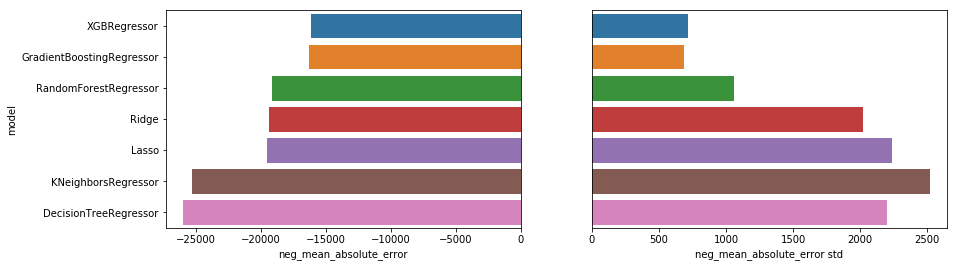

In [136]:
_, ax = plt.subplots(1, 2, figsize=(14, 4))
sns.barplot(x='cv_score_mean', y='model', data=df_out.head(7), ax=ax[0])
ax[0].set_xlabel('neg_mean_absolute_error')
sns.barplot(x='cv_score_std', y='model', data=df_out.head(7), ax=ax[1])
ax[1].set_xlabel('neg_mean_absolute_error std')
ax[1].yaxis.set_visible(False)

Let's use **XGBRegression** and train on the whole training set and produce prediction on test set.

In [116]:
model = xgboost.XGBRegressor()
model.fit(X_train, y_train)

rmsle = np.sqrt(metrics.mean_squared_log_error(y_train, model.predict(X_train)))
print("RMSLE on training set: ", rmsle)

# feature importance
df_feature = pd.DataFrame({'coef': model.feature_importances_}, index=feature_names).sort_values('coef', ascending=False)
df_feature.head(20)

[09:39:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE on training set:  0.09466215145170569


,coef
OverallQual,0.240725
ExterQual_TA,0.119625
GarageCars,0.116294
MSSubClass_60,0.053344
FullBath,0.051363
GrLivArea,0.032970
MSZoning_RM,0.025093
TotalBsmtSF,0.024947
CentralAir_Y,0.022849
GarageType_Attchd,0.020465


In [ ]:
# create prediction and submit
y_pred = model.predict(X_test)
make_submission_file(y_pred)

With XGBRegressor, basic missing value completion and no feature engineering, we received a PL score of 0.13921 (root mean square log error) on test set, ranking at 2218. It means on avearage, our prediction is around 14% off from actual value.

### Possible ways to improve the PL score

- Use PCA or cluster analysis to fix multicollinearity
- Automated feature selection. 
- (last step) hyper-parameter tuning.

Let's read some notebooks from Kaggle to get some inspiration.